In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from math import sin, cos, sqrt, atan2, radians

%matplotlib inline

In [2]:
housing_df = pd.read_csv('data/kc_house_data.csv', index_col='id')

### First look at the data

What does the data look like in a dataframe and a pairplot?

In [3]:
housing_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


There's at least one obviously errant data point wherein a certain house is purported to have 33 bedrooms. This is 3 times more than any other house in the dataset and the house's other features don't seem to be in line with this assertion, so we'll just fix that one data point (changing 33 to 3) before going further.

In [4]:
housing_df['bedrooms'] = housing_df['bedrooms'].apply(lambda x: 3 if x == 33 else x)

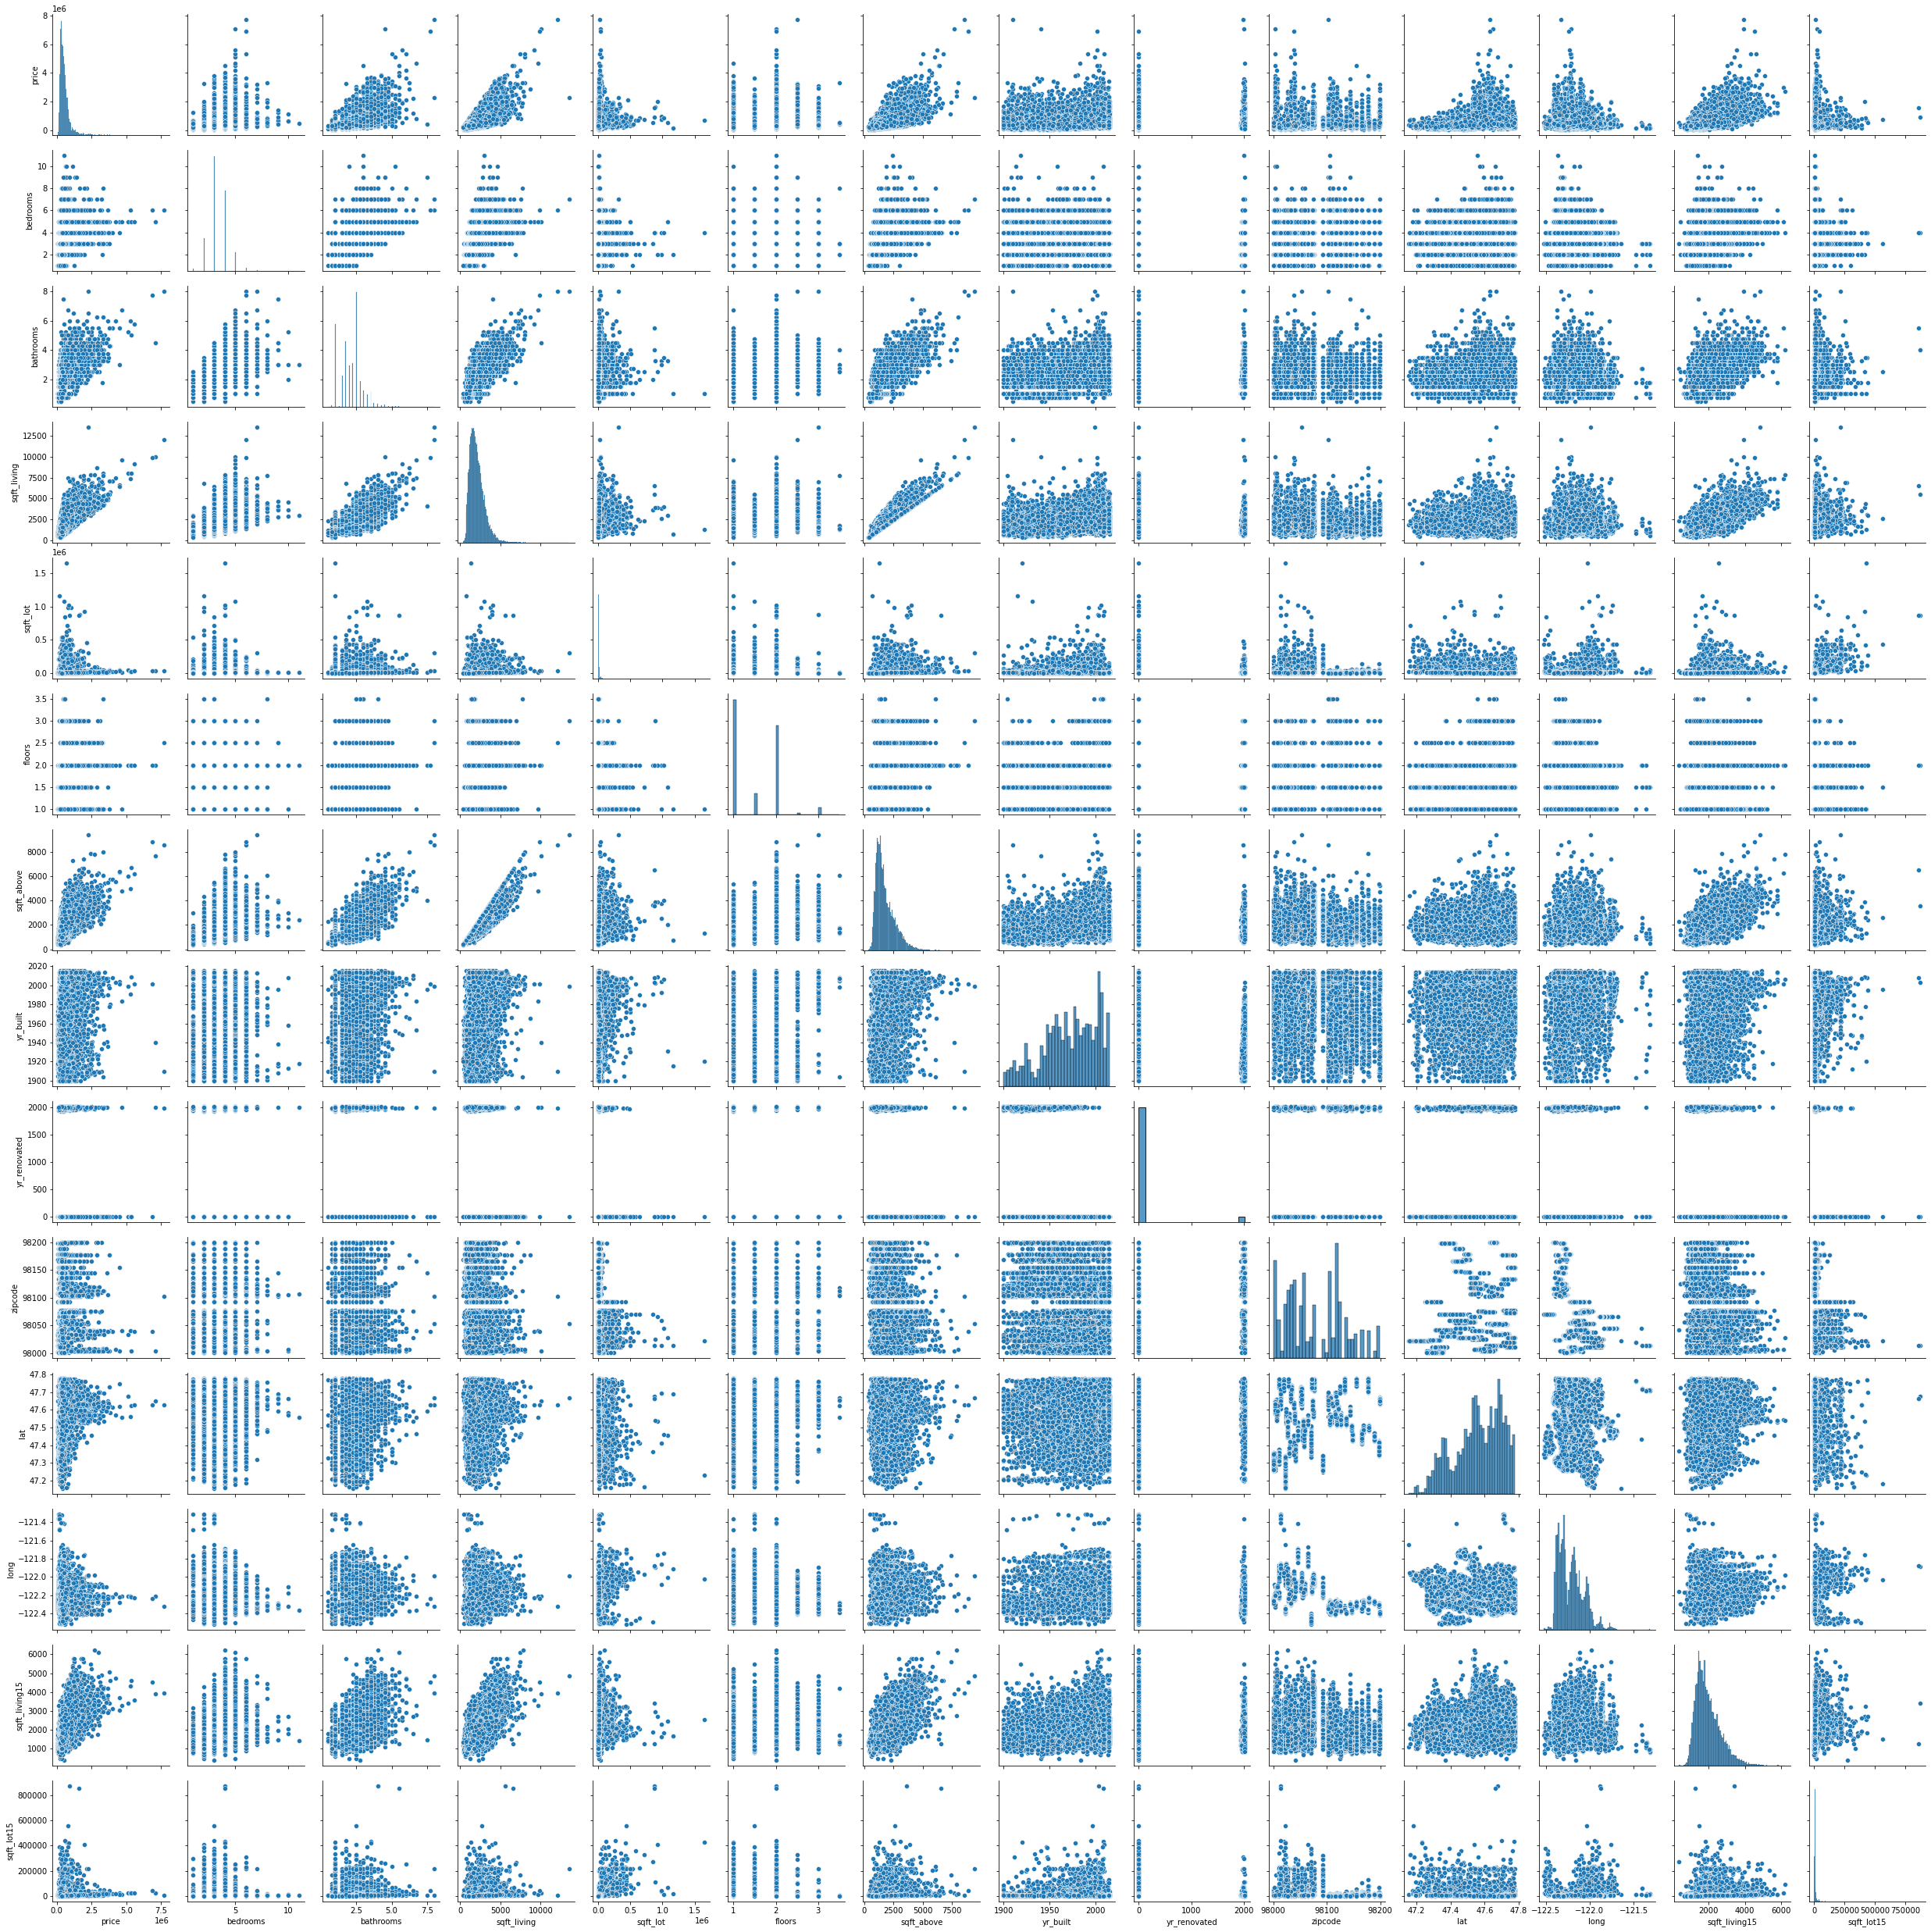

In [5]:
sns.pairplot(housing_df);

### Making a Train-Test Split
Before we go any further with any cleaning or other types of adjustments, we'll make a train-test split for later model evaluation.

In [6]:
X = housing_df.drop(['price'], axis=1)
y = housing_df['price']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=1)

From now on, any cleaning we do or models we build will use X_train and y_train instead of X and y.

### Filling in NaNs

Linear regression models will not run on dataframes which contain NaNs. These need to either be filled in with some sort of value or dropped. After looking at the proportions of missing data and in which columns they occur, we've decided to mostly replace NaNs with the mode of that column.

In [8]:
X_train.isna().sum()

date                0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       1898
view               45
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3095
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [9]:
# To avoid SettingWithCopyWarning errors down the line, we'll set each dataframe equal to a copy of itself
X_train, X_test, y_train, y_test = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

In [10]:
def nan_filler(df_to_clean):
    
    """
    This function takes a dataframe with NaNs
    in the waterfront, view, and yr_renovated 
    columns and ?s in the sqft_basement column
    and replaces them with the mode of that
    column.
    """
    
    column_missing_values_dict = {'waterfront': np.NaN, 'view': np.NaN, 'sqft_basement': '?', 'yr_renovated': np.NaN}

    for column_name, missing_value in column_missing_values_dict.items():
        imputer = SimpleImputer(missing_values=missing_value, strategy='most_frequent')
        df_to_clean[column_name] = imputer.fit_transform(df_to_clean[column_name].values.reshape(-1,1))[:,0]

In [11]:
nan_filler(X_train)
nan_filler(X_test)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 185000161 to 1762600320
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17277 non-null  object 
 1   bedrooms       17277 non-null  int64  
 2   bathrooms      17277 non-null  float64
 3   sqft_living    17277 non-null  int64  
 4   sqft_lot       17277 non-null  int64  
 5   floors         17277 non-null  float64
 6   waterfront     17277 non-null  object 
 7   view           17277 non-null  object 
 8   condition      17277 non-null  object 
 9   grade          17277 non-null  object 
 10  sqft_above     17277 non-null  int64  
 11  sqft_basement  17277 non-null  object 
 12  yr_built       17277 non-null  int64  
 13  yr_renovated   17277 non-null  float64
 14  zipcode        17277 non-null  int64  
 15  lat            17277 non-null  float64
 16  long           17277 non-null  float64
 17  sqft_living15  17277 non-null  int64 

### Fitting a model

Now we'll write a function to fit a linear regression and return several of it's metrics. We'll then fit a basic multiple linear regression to the data, dropping any columns that we have yet to convert to numerical data.

But first, we'll instantiate an empty dictionary to hold our test results. Normally we wouldn't score a model against the test data until the very end, but in this case, we'll hide these results from ourselves and only observe cross-validation results with each new model we train. We can then later examine all the test results of all of our different models, and examine their progress over time (or have a record of precisely where our modeling procedures have gone awry. 

In [13]:
#models_dict = {}

models_dict = {'Naive simple': (0.49, 249000), 'All continuous': (0.61, 222000)}

In [14]:
def model_fitter(X_mod, y_mod, X_test_mod, y_test_mod, model_name, drop_columns=None, sm_summary=False):
    
    """
    This function takes X and y training data and fits a 
    linear regression model to it. It will also score 
    this model against X and y test data and store the results 
    in a dictionary for later inspection. It will also optionally 
    display a statsmodels OLS summary for more detailed information 
    about the model.
    
    X_mod
    y_mod
    X_test_mod=None
    y_test_mod=None
    model_name=None (for results dictionary)
    drop_columns=None
    sm_summary=False
    """
    
    X_mod = X_mod.drop(drop_columns, axis=1).copy()
    X_test_mod = X_test_mod.drop(drop_columns, axis=1).copy()
    
    regression = LinearRegression()

    scores = cross_validate(
        estimator=regression,
        X=X_mod,
        y=y_mod,
        scoring=['neg_mean_squared_error', 'r2'],
        return_train_score=True,
        cv=None
    )

    print("Current Model")
    print("Train RMSE:      ", int(round(np.sqrt(scores["train_neg_mean_squared_error"]*-1).mean())))
    print("Train R^2:       ", round(scores["train_r2"].mean(), 3))
    print("Validation RMSE: ", int(round(np.sqrt(scores["test_neg_mean_squared_error"]*-1).mean())))
    print("Validation R^2:  ", round(scores["test_r2"].mean(), 3))
    
    regression = LinearRegression()
    regression.fit(X_mod, y_mod)
    
    y_hat = regression.predict(X_test_mod)
    rmse = np.sqrt(mean_squared_error(y_test_mod, y_hat))
    
    models_dict.update({model_name: (round(regression.score(X_test_mod, y_test_mod), 3), int(round((round(rmse / 1000)*1000))))})
    
    if sm_summary:
        return sm.OLS(y_train, sm.add_constant(X_mod)).fit().summary()

In [15]:
columns_to_drop = ['date', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement']
model_fitter(X_train, 
             y_train, 
             X_test, 
             y_test, 
             'All numeric', 
             drop_columns=columns_to_drop, 
             sm_summary=True
             )

Current Model
Train RMSE:       225510
Train R^2:        0.627
Validation RMSE:  225891
Validation R^2:   0.625


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     2235.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        04:30:36   Log-Likelihood:            -2.3748e+05
No. Observations:               17277   AIC:                         4.750e+05
Df Residuals:                   17263   BIC:                         4.751e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -1.07e+07   3.59e+06     -2.985      0.003   -1.77e+07   -3.67e+06
bedrooms      -6.508e+04   2446.118    -26.606      0.000   -6.99e+04   -6.03e+04
bathrooms      5.888e+04   4058.132     14.510      0.000    5.09e+04    6.68e+04
sqft_living     232.3347      5.330     43.586      0.000     221.886     242.783
sqft_lot          0.1730      0.059      2.938      0.003       0.058       0.288
floors         2.468e+04   4488.482      5.498      0.000    1.59e+04    3.35e+04
sqft_above       34.0002      5.345      6.362      0.000      23.524      44.476
yr_built      -2498.2269     82.979    -30.107      0.000   -2660.875   -2335.579
yr_renovated     34.7034      4.926      7.045      0.000      25.049      44.358
zipcode        -589.8496     40.742    -14.478      0.000    -669.707    -509.992
lat            6.227e+05   1.32e+04     47.352      0.000    5.97e+05    6.48e+05
long           -3.58e+05   1.63e+04    -21.935      0.000    -3.9e+05   -3.26e+05
sqft_living15    81.5261      4.071     20.024      0.000      73.546      89.506
sqft_lot15       -0.4269      0.089     -4.812      0.000      -0.601      -0.253
==============================================================================
Omnibus:                    14170.132   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1008941.718
Skew:                           3.476   Prob(JB):                         0.00
Kurtosis:                      39.786   Cond. No.                     2.10e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Cleaning up important columns

The waterfront, view, condition, and grade columns should all be numeric. We'll clean those up with a few assorted in-place adjustments.

In [16]:
X_train['grade'].value_counts()

7 Average        7145
8 Good           4850
9 Better         2101
6 Low Average    1632
10 Very Good      924
11 Excellent      322
5 Fair            202
12 Luxury          67
4 Low              21
13 Mansion         12
3 Poor              1
Name: grade, dtype: int64

In [17]:
X_train.loc[:,'grade'] = X_train.copy().loc[:,'grade'].apply(lambda x: int(x[0]))
X_test.loc[:,'grade'] = X_test.copy().loc[:,'grade'].apply(lambda x: int(x[0]))
X_train['grade'].value_counts()

7    7145
8    4850
9    2101
6    1632
1    1325
5     202
4      21
3       1
Name: grade, dtype: int64

In [18]:
print(X_train['view'].value_counts())
print(X_train['condition'].value_counts())
print(X_train['waterfront'].value_counts())

NONE         15555
AVERAGE        783
GOOD           410
FAIR           279
EXCELLENT      250
Name: view, dtype: int64
Average      11206
Good          4542
Very Good     1378
Fair           130
Poor            21
Name: condition, dtype: int64
NO     17160
YES      117
Name: waterfront, dtype: int64


We'll write a quick label encoding function. There is a method to do this automatically, but we would like to keep the categories in a specific order, whereas the automatic label encoder would not produce our desired ordering. 

In [19]:
def label_encode(df):
    
    """
    This function takes a data and label encodes some of the
    categorical variables.
    """

    view_values = ['NONE', 'FAIR', 'AVERAGE', 'GOOD', 'EXCELLENT']
    condition_values = ['Poor', 'Fair', 'Average', 'Good', 'Very Good']
    waterfront_values = ['NO', 'YES']

    values_dict = {'view': view_values, 'condition': condition_values, 'waterfront': waterfront_values}

    for column_name, values_list in values_dict.items():    
        for num, value in enumerate(values_list):
            df.loc[df[column_name] == value, column_name] = int(num)
        df[column_name] = df[column_name].astype(int)

In [20]:
label_encode(X_train)
label_encode(X_test)

In [21]:
X_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
185000161,10/15/2014,3,1.00,1780,7800,1.0,0,0,2,7,1060,720.0,1957,0.0,98178,47.4932,-122.263,1450,7800
2767601311,10/24/2014,3,2.50,1260,1102,3.0,0,0,2,8,1260,0.0,2007,0.0,98107,47.6750,-122.387,1320,2500
7131300063,4/29/2015,4,1.75,2140,4959,1.0,0,0,2,7,1080,1060.0,1965,0.0,98118,47.5166,-122.266,1590,5250
8910500226,4/9/2015,3,3.50,1340,1168,2.0,0,2,2,8,1080,260.0,2002,0.0,98133,47.7110,-122.356,1650,1378
5230300210,12/10/2014,3,1.00,1040,9514,1.0,0,0,3,7,1040,0.0,1969,0.0,98059,47.4936,-122.102,1040,9514


We'll also convert the date column to pandas datetime values and the sqft_basement and grade columns into numeric columns.

In [22]:
X_train.loc[:, 'date'] = pd.to_datetime(X_train.loc[:, 'date'])
X_test.loc[:, 'date'] = pd.to_datetime(X_test.loc[:, 'date'])
X_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
185000161,2014-10-15,3,1.00,1780,7800,1.0,0,0,2,7,1060,720.0,1957,0.0,98178,47.4932,-122.263,1450,7800
2767601311,2014-10-24,3,2.50,1260,1102,3.0,0,0,2,8,1260,0.0,2007,0.0,98107,47.6750,-122.387,1320,2500
7131300063,2015-04-29,4,1.75,2140,4959,1.0,0,0,2,7,1080,1060.0,1965,0.0,98118,47.5166,-122.266,1590,5250
8910500226,2015-04-09,3,3.50,1340,1168,2.0,0,2,2,8,1080,260.0,2002,0.0,98133,47.7110,-122.356,1650,1378
5230300210,2014-12-10,3,1.00,1040,9514,1.0,0,0,3,7,1040,0.0,1969,0.0,98059,47.4936,-122.102,1040,9514


In [23]:
X_train['sqft_basement'] = X_train['sqft_basement'].astype(float)
X_train['grade'] = X_train['grade'].astype(int)

X_test['sqft_basement'] = X_test['sqft_basement'].astype(float)
X_test['grade'] = X_test['grade'].astype(int)

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17277 entries, 185000161 to 1762600320
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           17277 non-null  datetime64[ns]
 1   bedrooms       17277 non-null  int64         
 2   bathrooms      17277 non-null  float64       
 3   sqft_living    17277 non-null  int64         
 4   sqft_lot       17277 non-null  int64         
 5   floors         17277 non-null  float64       
 6   waterfront     17277 non-null  int64         
 7   view           17277 non-null  int64         
 8   condition      17277 non-null  int64         
 9   grade          17277 non-null  int64         
 10  sqft_above     17277 non-null  int64         
 11  sqft_basement  17277 non-null  float64       
 12  yr_built       17277 non-null  int64         
 13  yr_renovated   17277 non-null  float64       
 14  zipcode        17277 non-null  int64         
 15  lat   

### Now we'll train a model using all the columns, except for date.

In [25]:
columns_to_drop = ['date']
model_fitter(X_train, 
             y_train, 
             X_test, 
             y_test, 
             'All original features', 
             drop_columns=columns_to_drop, 
             sm_summary=True
             )

Current Model
Train RMSE:       207856
Train R^2:        0.683
Validation RMSE:  208408
Validation R^2:   0.68


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     2068.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        04:30:42   Log-Likelihood:            -2.3607e+05
No. Observations:               17277   AIC:                         4.722e+05
Df Residuals:                   17258   BIC:                         4.723e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.364e+06   3.37e+06     -0.405      0.685   -7.96e+06    5.24e+06
bedrooms      -4.439e+04   2299.013    -19.306      0.000   -4.89e+04   -3.99e+04
bathrooms      5.287e+04   3750.408     14.098      0.000    4.55e+04    6.02e+04
sqft_living     146.0670     22.516      6.487      0.000     101.934     190.200
sqft_lot          0.1260      0.054      2.318      0.020       0.019       0.233
floors         3.232e+04   4170.916      7.750      0.000    2.41e+04    4.05e+04
waterfront     6.024e+05   2.09e+04     28.812      0.000    5.61e+05    6.43e+05
view           5.936e+04   2430.499     24.425      0.000    5.46e+04    6.41e+04
condition      3.158e+04   2710.764     11.649      0.000    2.63e+04    3.69e+04
grade         -2.229e+04    893.313    -24.950      0.000    -2.4e+04   -2.05e+04
sqft_above       84.8629     22.450      3.780      0.000      40.859     128.867
sqft_basement    41.7527     22.293      1.873      0.061      -1.945      85.450
yr_built      -1754.2940     81.478    -21.531      0.000   -1914.000   -1594.588
yr_renovated     36.7210      4.612      7.963      0.000      27.682      45.760
zipcode        -660.7730     37.952    -17.411      0.000    -735.164    -586.382
lat            6.774e+05   1.22e+04     55.566      0.000    6.54e+05    7.01e+05
long          -3.062e+05   1.51e+04    -20.292      0.000   -3.36e+05   -2.77e+05
sqft_living15    58.6668      3.827     15.328      0.000      51.165      66.169
sqft_lot15       -0.4814      0.082     -5.883      0.000      -0.642      -0.321
==============================================================================
Omnibus:                    13438.452   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1076477.788
Skew:                           3.143   Prob(JB):                         0.00
Kurtosis:                      41.156   Cond. No.                     2.14e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Implementing dummy variables

In [26]:
grade_dummies = pd.get_dummies(X_train['grade'], prefix='grd', drop_first=True)
view_dummies = pd.get_dummies(X_train['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(X_train['condition'], prefix='cond', drop_first=True)
waterfront_dummies = pd.get_dummies(X_train['waterfront'], prefix='wtrfrnt', drop_first=True)

X_train_dummies = X_train.drop(['grade', 'view', 'condition', 'waterfront'], axis=1)
X_train_dummies = pd.concat([X_train_dummies, grade_dummies, view_dummies, condition_dummies, waterfront_dummies], axis=1)

grade_dummies = pd.get_dummies(X_test['grade'], prefix='grd', drop_first=True)
view_dummies = pd.get_dummies(X_test['view'], prefix='view', drop_first=True)
condition_dummies = pd.get_dummies(X_test['condition'], prefix='cond', drop_first=True)
waterfront_dummies = pd.get_dummies(X_test['waterfront'], prefix='wtrfrnt', drop_first=True)

X_test = X_test.drop(['grade', 'view', 'condition', 'waterfront'], axis=1)
X_test = pd.concat([X_test, grade_dummies, view_dummies, condition_dummies, waterfront_dummies], axis=1)

X_test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,...,grd_9,view_1,view_2,view_3,view_4,cond_1,cond_2,cond_3,cond_4,wtrfrnt_1
id,,,,,,,,,,,,,,,,,,,,,
8562000010,2015-05-01,3,1.75,1210,8864,1.0,1210,0.0,1985,0.0,...,0,0,0,0,0,0,1,0,0,0
4363700200,2015-03-25,4,1.00,1190,7920,1.0,890,300.0,1951,0.0,...,0,0,0,0,0,0,1,0,0,0
8165501620,2014-12-18,2,2.25,1550,1824,2.0,1550,0.0,2007,0.0,...,0,0,0,0,0,0,1,0,0,0
8718500075,2014-11-17,3,1.50,1300,8280,1.0,1300,0.0,1956,0.0,...,0,0,0,0,0,0,0,0,1,0
6154900005,2014-09-24,4,2.75,2420,7102,1.0,1670,750.0,1946,0.0,...,0,0,0,0,0,0,0,0,1,0


In [27]:
set(X_train_dummies.columns) - set(X_test.columns)

{'grd_3'}

In [28]:
missing_columns = set(X_train_dummies.columns) - set(X_test.columns)

for column in missing_columns:
    X_test[column] = 0

In [29]:
columns_to_drop = ['date']
model_fitter(X_train_dummies, 
             y_train, 
             X_test, 
             y_test, 
             'Added dummies', 
             drop_columns=columns_to_drop, 
             sm_summary=False
             )

Current Model
Train RMSE:       202193
Train R^2:        0.7
Validation RMSE:  203015
Validation R^2:   0.697


### Feature Engineering

Here we'll engineer a few features to see if that improves our model's score at all. We'll start with distance to Seattle and distance to Redmond.

In [30]:
def get_distance(point1, point2):
    R = 6370
    lat1 = radians(point1[0])
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2- lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

# We will use the coordinates of the city halls of Seattle: (47.60457618602064, -122.32993003068658),
# and Redmond: (47.679328831807894, -122.13055895937767)
# For each record, we will calculate the distance from those points of interests and place them in a new column

X_train_features = X_train_dummies.copy()
X_train_features['lat_long'] = list(zip(X_train_features['lat'], X_train_features['long']))
X_train_features['Seattle_dist_km'] = X_train_features['lat_long'].apply(lambda x: get_distance(x, (47.60457618602064, -122.32993003068658)))
X_train_features['Redmond_dist_km'] = X_train_features['lat_long'].apply(lambda x: get_distance(x, (47.679328831807894, -122.13055895937767)))

X_train_features.drop('lat_long', axis=1, inplace=True)

X_test['lat_long'] = list(zip(X_test['lat'], X_test['long']))
X_test['Seattle_dist_km'] = X_test['lat_long'].apply(lambda x: get_distance(x, (47.60457618602064, -122.32993003068658)))
X_test['Redmond_dist_km'] = X_test['lat_long'].apply(lambda x: get_distance(x, (47.679328831807894, -122.13055895937767)))

X_test.drop('lat_long', axis=1, inplace=True)

In [31]:
columns_to_drop = ['date']
model_fitter(X_train_features, 
             y_train, 
             X_test, 
             y_test, 
             'Engineered city-centers feature', 
             drop_columns=columns_to_drop, 
             sm_summary=False
             )

Current Model
Train RMSE:       190613
Train R^2:        0.734
Validation RMSE:  191295
Validation R^2:   0.731


### It only gets worse from here...

It looks as though each additional technique we apply to our models doesn't seem to offer any benefits and in fact increases our error.

In [32]:
X_train_features2 = X_train_features
X_test_mock = X_test

# We can also include another feature: "average room size"
X_train_features2['average_room_size'] = X_train_features2['sqft_living'] / (X_train['bathrooms'] + X_train['bedrooms'])
X_test['average_room_size'] = X_test['sqft_living'] / (X_test_mock['bathrooms'] + X_test_mock['bedrooms'])

# Another useful metric could be the Floor Area Ratio
X_train_features2['floor_area_ratio'] = X_train_features2['sqft_living'] / X_train_features2['sqft_lot']
X_test['floor_area_ratio'] = X_test['sqft_living'] / X_test['sqft_lot']

In [33]:
columns_to_drop = ['date']
model_fitter(X_train_features2, 
             y_train, 
             X_test, 
             y_test, 
             'More features engineered', 
             drop_columns=columns_to_drop, 
             sm_summary=False
             )

Current Model
Train RMSE:       185598
Train R^2:        0.748
Validation RMSE:  187096
Validation R^2:   0.742


### Log Transformations

We'll try a few log transformations in order to normalize some of our data. We can't log transform any categorical variables because they're all in one-hot encoding, but the other continuous variables are worth examining.

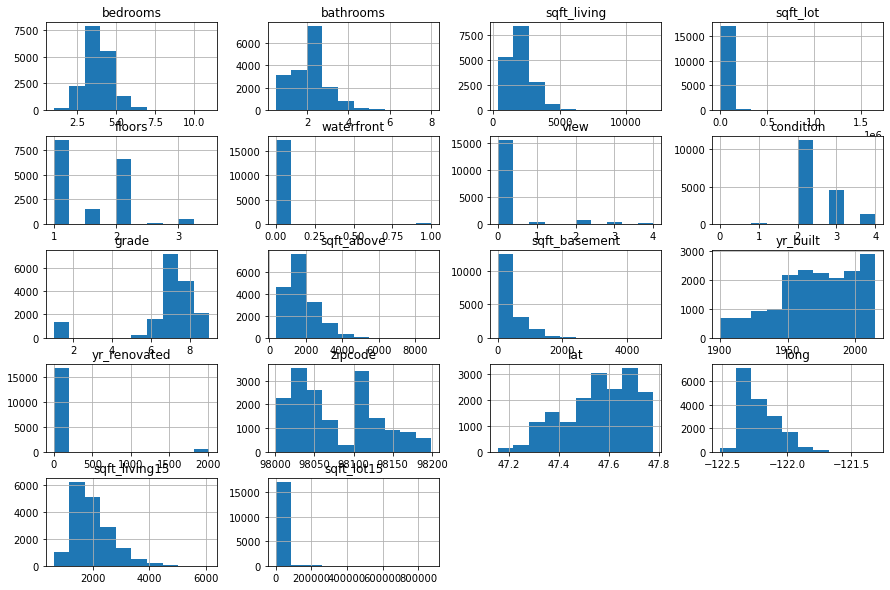

In [34]:
X_train.hist(figsize=(15,10));

In [35]:
X_train_log = X_train_features2

non_normal = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']

for feat in non_normal:
    X_train_log[f'log{feat}'] = X_train_log[feat].map(lambda x: np.log(x))
    
for feat in non_normal:
    X_test[f'log{feat}'] = X_test[feat].map(lambda x: np.log(x))

In [36]:
columns_to_drop = ['date']
model_fitter(X_train_log, 
             y_train, 
             X_test, 
             y_test, 
             'Log transformations', 
             drop_columns=columns_to_drop, 
             sm_summary=True
             )

Current Model
Train RMSE:       183639
Train R^2:        0.753
Validation RMSE:  185305
Validation R^2:   0.747


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     1343.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        04:30:55   Log-Likelihood:            -2.3394e+05
No. Observations:               17277   AIC:                         4.680e+05
Df Residuals:                   17237   BIC:                         4.683e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.219e+08   4.24e+06     28.784      0.000    1.14e+08     1.3e+08
bedrooms           -6.23e+04   5389.514    -11.560      0.000   -7.29e+04   -5.17e+04
bathrooms          -901.1534   5963.415     -0.151      0.880   -1.26e+04    1.08e+04
sqft_living         402.8849     22.886     17.604      0.000     358.026     447.744
sqft_lot              0.0651      0.061      1.065      0.287      -0.055       0.185
floors             -1.71e+04   4525.746     -3.779      0.000    -2.6e+04   -8231.840
sqft_above           34.9260     22.644      1.542      0.123      -9.458      79.310
sqft_basement        30.6745     19.741      1.554      0.120      -8.019      69.368
yr_built          -1386.1013     81.378    -17.033      0.000   -1545.610   -1226.593
yr_renovated         36.3201      4.109      8.840      0.000      28.267      44.373
zipcode            -984.8370     37.725    -26.106      0.000   -1058.782    -910.892
lat                5.876e+05   2.89e+04     20.352      0.000    5.31e+05    6.44e+05
long               3.949e+05   2.31e+04     17.061      0.000     3.5e+05     4.4e+05
sqft_living15         6.9594     12.158      0.572      0.567     -16.871      30.789
sqft_lot15           -0.2456      0.095     -2.573      0.010      -0.433      -0.058
grd_3             -2.129e+05   1.85e+05     -1.152      0.250   -5.75e+05     1.5e+05
grd_4              -4.91e+05   4.22e+04    -11.641      0.000   -5.74e+05   -4.08e+05
grd_5             -4.016e+05   1.67e+04    -24.026      0.000   -4.34e+05   -3.69e+05
grd_6             -3.384e+05   1.06e+04    -31.991      0.000   -3.59e+05   -3.18e+05
grd_7             -2.596e+05   8769.555    -29.598      0.000   -2.77e+05   -2.42e+05
grd_8              -2.14e+05   7949.423    -26.920      0.000    -2.3e+05   -1.98e+05
grd_9             -1.446e+05   7373.804    -19.613      0.000   -1.59e+05    -1.3e+05
view_1             1.048e+05   1.13e+04      9.259      0.000    8.26e+04    1.27e+05
view_2              6.73e+04   7006.381      9.605      0.000    5.36e+04     8.1e+04
view_3             1.273e+05   9682.281     13.145      0.000    1.08e+05    1.46e+05
view_4             3.118e+05   1.45e+04     21.524      0.000    2.83e+05     3.4e+05
cond_1             8.019e+04   4.36e+04      1.839      0.066   -5294.965    1.66e+05
cond_2              9.94e+04   4.07e+04      2.440      0.015    1.95e+04    1.79e+05
cond_3             1.362e+05   4.08e+04      3.341      0.001    5.63e+04    2.16e+05
cond_4             1.701e+05    4.1e+04      4.151      0.000    8.98e+04     2.5e+05
wtrfrnt_1          5.574e+05   2.07e+04     26.930      0.000    5.17e+05    5.98e+05
Seattle_dist_km   -1.587e+04    463.623    -34.239      0.000   -1.68e+04    -1.5e+04
Redmond_dist_km    7076.9482    515.662     13.724      0.000    6066.199

In [37]:
columns_to_drop = ['date', 'bathrooms', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'logsqft_lot15']
model_fitter(X_train_log, 
             y_train, 
             X_test, 
             y_test, 
             'Dropping columns', 
             drop_columns=columns_to_drop, 
             sm_summary=False
             )

Current Model
Train RMSE:       183689
Train R^2:        0.753
Validation RMSE:  185089
Validation R^2:   0.747


### Examining our test scores

In [38]:
models_dict

{'Naive simple': (0.49, 249000),
 'All continuous': (0.61, 222000),
 'All numeric': (0.637, 216000),
 'All original features': (0.694, 198000),
 'Added dummies': (0.659, 210000),
 'Engineered city-centers feature': (0.696, 198000),
 'More features engineered': (0.681, 202000),
 'Log transformations': (0.66, 209000),
 'Dropping columns': (0.66, 209000)}

In [39]:
models_dict.update({'Continuous, plus engineered features\nNo Dummies': (.694, 196000), 'All features, No dummies': (.771, 169000)})
models_dict

{'Naive simple': (0.49, 249000),
 'All continuous': (0.61, 222000),
 'All numeric': (0.637, 216000),
 'All original features': (0.694, 198000),
 'Added dummies': (0.659, 210000),
 'Engineered city-centers feature': (0.696, 198000),
 'More features engineered': (0.681, 202000),
 'Log transformations': (0.66, 209000),
 'Dropping columns': (0.66, 209000),
 'Continuous, plus engineered features\nNo Dummies': (0.694, 196000),
 'All features, No dummies': (0.771, 169000)}

### Illustrating our progress over time

We'll use our test score data to make a graph of our progress over time. We'll use a double-y-axis graph showing R^2 as a bar chart and RMSE as a line graph. 

In [40]:
x_error = []
xticklabels = []
y = []

for model_name, model_metric in models_dict.items():
    xticklabels.append(model_name)
    y.append(model_metric[0])
    x_error.append(model_metric[1])

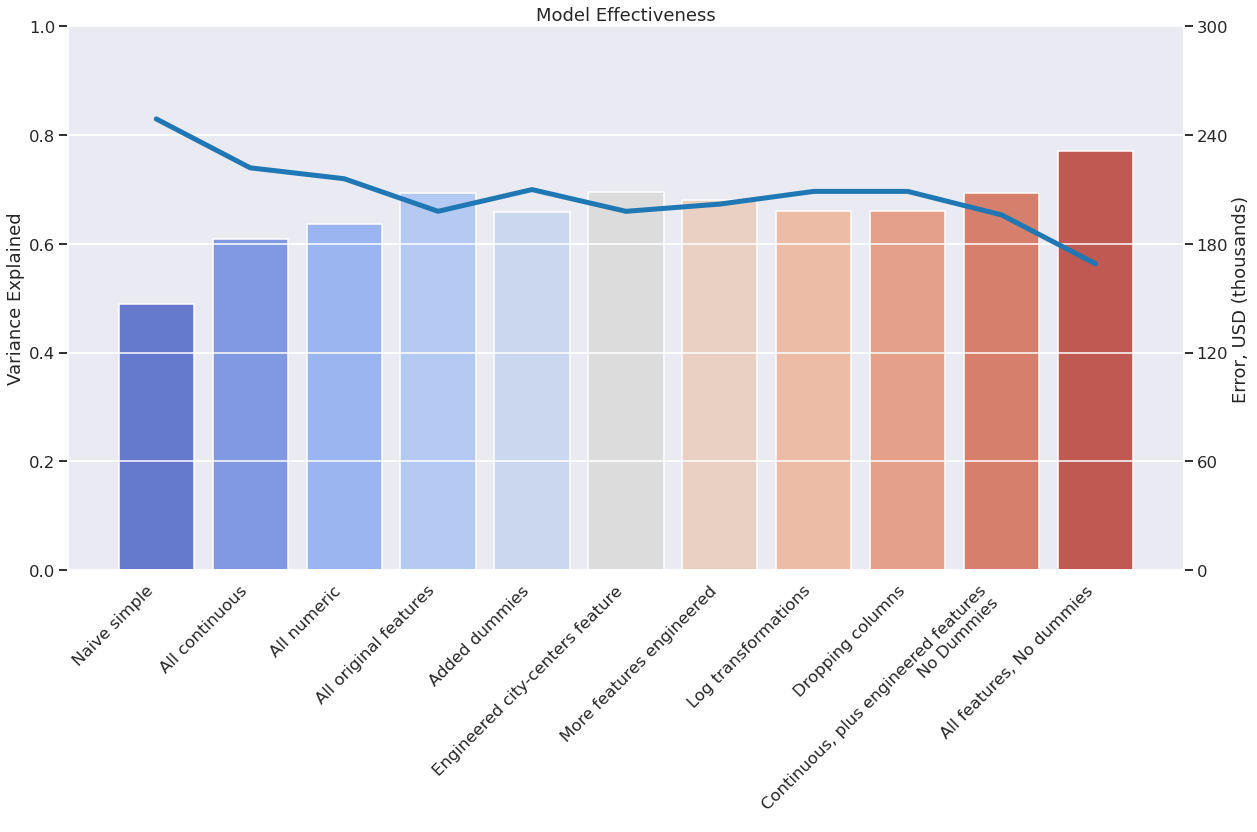

In [41]:
sns.set_style('darkgrid')
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(x=xticklabels, y=y, palette="coolwarm")
ax.set(ylim=(0, 1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

ax2 = ax.twinx()
sns.lineplot(x=xticklabels, y=x_error, linewidth=5)
ax2.set(ylim=(0, 300000))
ax2.set_yticks(np.linspace(0,300000,num=6))
ax2.set_yticklabels(np.linspace(0,300,num=6,dtype=int))

ax.set_ylabel('Variance Explained')
ax2.set_ylabel('Error, USD (thousands)')
ax.set_title('Model Effectiveness')
plt.savefig('../../../Downloads/the_skylar_slide_phase2', dpi=600, transparent=False, bbox_inches='tight', pad_inches=1);